In [ ]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [214]:
results_path = "/Users/wvw/git/n3/sparql2n3/SPARQL-to-N3/gmark_50_new/mix"
desc_path = "/Users/wvw/git/n3/sparql2n3/SPARQL-to-N3/SPIN-to-N3/property-paths/results/gmark"
systems = [ 'jena', 'rdf4j', 'rdflib', 'direct', 'fwd', 'bwd' ]
data_sizes = [ "50", "100" ]
dataset_to_id = [ len("data_"), -len(".n3") ]
sparql_to_id = [ len("query-"), -len(".sparql") ]
n3_to_id = [ len("query-"), -len(".n3") ]
queries = [ f"query-{i}" for i in range(0, 50) ]

In [ ]:
# results_path = "/Users/wvw/git/n3/sparql2n3/SPARQL-to-N3/SPIN-to-N3/property-paths/zika"
# desc_path = "/Users/wvw/git/n3/sparql2n3/SPARQL-to-N3/SPIN-to-N3/property-paths/results/zika"
# systems = 'jena', 'direct', 'fwd', 'bwd'
# data_sizes = "1_000_pt2", "2_000_pt2", "5_000_pt2", "7_000_pt2", "10_000_pt2"
# dataset_to_id = [ len("data_"), -len("-pt2.nt") ]
# query_to_id = [ 0, -len(".sparql") ]
# queries = [ f"pp{i}" for i in range(1, 5) ]

## Load results

In [228]:
def load_sparql_times(system, data_size=None):
    root = f"{results_path}/results/{system}"
    if data_size is None:
        df_sparql = pd.concat([pd.read_csv(os.path.join(
            root, folder, f"times_{system}.csv")) for folder in os.listdir(root) if not folder.startswith(".")])
    else:
        df_sparql = pd.read_csv(os.path.join(
            root, data_size, f"times_{system}.csv"))

    df_sparql['total_time'] = df_sparql['load_time'] + df_sparql['exec_time']
    return df_sparql


def __sparql_agg(df_sparql, grouper):
    df_sparql_agg = df_sparql.groupby(
        grouper)[['load_time', 'exec_time', 'total_time']].mean().reset_index()

    return df_sparql_agg


def load_sparql_agg_dataset(system, data_size):
    df_sparql = load_sparql_times(system, data_size)

    df_sparql_agg = __sparql_agg(df_sparql, "query")
    df_sparql_agg['id'] = df_sparql_agg['query'].str.slice(
        sparql_to_id[0], sparql_to_id[1])

    return df_sparql_agg


def load_sparql_agg_query(system, query):
    df_sparql = load_sparql_times(system)
    df_sparql = df_sparql[df_sparql['query'] == query]

    df_sparql_agg = __sparql_agg(df_sparql, "data")
    df_sparql_agg['id'] = df_sparql_agg['data'].str.slice(
        dataset_to_id[0], dataset_to_id[1]).astype(int)
    df_sparql_agg = df_sparql_agg.sort_values(by='id')

    return df_sparql_agg


def load_sparql_agg(system):
    df_sparql = load_sparql_times(system)

    df_sparql_agg = __sparql_agg(df_sparql, "data")
    df_sparql_agg['id'] = df_sparql_agg['data'].str.slice(
        dataset_to_id[0], dataset_to_id[1]).astype(int)
    df_sparql_agg = df_sparql_agg.sort_values(by='id')

    return df_sparql_agg

In [229]:
def __load_n3_time(path):
    df_n3 = pd.read_csv(path)

    # drop all times for query with at least 1 failed phase
    df_n3['id'] = df_n3.apply(lambda x: f"{x['query']},{x['type']}", axis=1)
    df_n3_failed = df_n3[df_n3['reas_time'] == -1]['id']
    df_n3_filt = df_n3[~df_n3['id'].isin(df_n3_failed)]

    return df_n3_filt


def load_n3_times(type, data_size=None):
    root = f"{results_path}/n3/results"
    if data_size is None:
        df_n3 = pd.concat([__load_n3_time(os.path.join(
            root, folder, f"times_n3.csv")) for folder in os.listdir(root) if not folder.startswith(".")])
    else:
        df_n3 = __load_n3_time(os.path.join(
            root, data_size, f"times_n3.csv"))

    df_n3 = df_n3[df_n3['type'] == type]

    df_n3_total = df_n3[df_n3['phase'].isna() | (
        df_n3['phase'] == 'total')]
    df_n3_total['total_time'] = df_n3_total['netw_time'] + \
        df_n3_total['reas_time']

    return df_n3_total


def __n3_agg(df_n3, grouper):
    df_n3_agg = df_n3.groupby(
        grouper)[['netw_time', 'reas_time', 'total_time']].mean().reset_index()

    return df_n3_agg


def load_n3_agg_dataset(type, data_size):
    df_n3 = load_n3_times(type, data_size)

    df_n3_agg = __n3_agg(df_n3, "query")
    df_n3_agg['id'] = df_n3_agg['query'].str.slice(
        n3_to_id[0], n3_to_id[1])

    return df_n3_agg


def load_n3_agg_query(type, query):
    df_n3 = load_n3_times(type)
    df_n3 = df_n3[df_n3['query'] == query]

    df_n3_agg = __n3_agg(df_n3, "data")
    df_n3_agg['id'] = df_n3_agg['data'].str.slice(
        dataset_to_id[0], dataset_to_id[1]).astype(int)
    df_n3_agg = df_n3_agg.sort_values(by='id')

    return df_n3_agg


def load_n3_agg(type):
    df_n3 = load_n3_times(type)

    df_n3_agg = __n3_agg(df_n3, "data")
    df_n3_agg['id'] = df_n3_agg['data'].str.slice(
        dataset_to_id[0], dataset_to_id[1]).astype(int)
    df_n3_agg = df_n3_agg.sort_values(by='id')

    return df_n3_agg

## Check outliers

In [ ]:
def check_query_stdev(df, time_col, limit=10):
    for query in df['query'].unique():
        df_query = df[df['query']==query]
        stdev = df_query[time_col].describe()['std']
        if stdev > limit:
            print(query, "stdev:", stdev)
            print(df_query)
            print()

In [ ]:
# check_query_stdev(load_sparql_times('jena', 50), time_col='exec_time', limit=50)
# check_query_stdev(load_sparql_times('jena', 100),time_col='exec_time',  limit=50)

## - jena, data_size 100:
# outliers (exec time): query-11 (100637 vs. avg. 153), query-2 (309138 vs. avg. 39551)
# (replaced with averages)

check_query_stdev(load_sparql_times('jena', "1_000_pt2"), time_col='exec_time', limit=50)

In [ ]:
check_query_stdev(load_sparql_times('rdflib', 50), time_col='exec_time', limit=50)

In [ ]:
check_query_stdev(load_sparql_times('rdf4j', 50), time_col='exec_time', limit=100)
check_query_stdev(load_sparql_times('rdf4j', 100), time_col='exec_time', limit=100)

In [ ]:
# check_query_stdev(load_n3_times('fwd', 50), time_col='reas_time', limit=50)
# check_query_stdev(load_n3_times('fwd', 100), time_col='reas_time', limit=50)

check_query_stdev(load_n3_times('direct', "10_000_pt2"), time_col='reas_time', limit=100)
check_query_stdev(load_n3_times('bwd', "10_000_pt2"), time_col='reas_time', limit=100)
check_query_stdev(load_n3_times('fwd', "10_000_pt2"), time_col='reas_time', limit=100)

## Check statistics

### Per query

In [ ]:
# (only for zika)

for data_size in data_sizes:
    
    results = []
    for system in systems:
        if system == 'jena':
            res = load_sparql_agg_dataset('jena', data_size)
            name = system
        else:
            res = load_n3_agg_dataset(system, data_size)
            name = f"n3_{system}"
        
        res = res[res['id'].isin(queries)]
        res.to_csv(f"{results_path}/../results/zika/per_query/{name}-{data_size}.csv")
        results.append(res)
    
    all_res = None
    for system, res in zip(systems, results):
        res_col = ('exec_time' if system == 'jena' else 'reas_time')
        res_filt = res[['id', res_col]]
        
        if all_res is None:
            all_res = res_filt
        else:
            all_res = pd.merge(all_res, res_filt, on='id')
        all_res = all_res.rename(columns={res_col: system})
    
    print(data_size)
    print(all_res)

### Overall

In [ ]:
def describe_sparql(system, data_size, to_file=True):
    global desc_path
    
    res = load_sparql_agg_dataset(system, data_size)
    res = res[res['id'].isin(queries)]
    de = res.describe()
    
    if not to_file:
        print(system, data_size, "\n", de)
    else:
        de.to_csv(os.path.join(desc_path, f"{system}-{data_size}.csv"))
    
def describe_n3(type, data_size, to_file=True):
    global desc_path
    
    res = load_n3_agg_dataset(type, data_size)
    res = res[res['id'].isin(queries)]
    de = res.describe()
    
    if not to_file:
        print("n3", type, data_size, "\n", de)
    else:
        de.to_csv(os.path.join(desc_path, f"n3_{type}-{data_size}.csv"))

In [ ]:
for system in systems:
    for data_size in data_sizes:
        
        if system == 'jena':
            describe_sparql(system, data_size)
        else:
            describe_n3(system, data_size)

### Aggregate

In [248]:
all_res = None
for system in [ 'jena', 'fwd' ]: #, 'bwd', 'direct' ]:
    if system == 'jena' or system == 'rdf4j' or system == 'rdflib':
        res = load_sparql_agg(system)
        res = res[['id', 'exec_time']]
        res = res.rename(columns={"exec_time": system})
    else:
        res = load_n3_agg(system)
        res = res[['id', 'reas_time']]
        res = res.rename(columns={"reas_time": system})

    if all_res is None:
        all_res = res
    else:
        all_res = pd.merge(all_res, res, on='id')
        
all_res

,id,jena,fwd
0,50,202.424000,103.448000
1,100,1687.285714,326.106122


## Plot

In [220]:
import matplotlib.pyplot as plt

def plot_query(name, incl_n3, incl_sparql, lim=None, ax=None, sys_label=False):
    if ax is None:
        fig, ax = plt.subplots()
        if lim is not None:
            ax.set_ylim(0, lim)
        ax.set_title(name)

    n3_query = f"{name}.n3"
    for method in incl_n3:
        label = (f"{name} -- {method}" if sys_label else method)
        load_n3_agg_query(method, n3_query).plot(x='id', y='reas_time', ax=ax, label=label)

    sparql_query = f"{name}.sparql"
    for system in incl_sparql:
        label = (f"{name} -- {system}" if sys_label else system)
        load_sparql_agg_query(system, sparql_query).plot(x='id', y='exec_time', ax=ax, label=label)
        
        
# (only for zika)
def plot_system(system, incl_only=['pp1', 'pp2', 'pp3', 'pp4']):
    fig, ax = plt.subplots()
    ax.set_title(system)
    
    def my_plot(query, system):
        nonlocal ax
        if system == 'jena':
            sparql_query = f"{query}.sparql"
            load_sparql_agg_query(system, sparql_query).plot(x='id', y='exec_time', ax=ax, label=query)
        else:
            n3_query = f"{query}.n3"
            load_n3_agg_query(system, n3_query).plot(x='id', y='reas_time', ax=ax, label=query)
    
    for query in queries:
        if query in incl_only:
            my_plot(query, system)
            
import matplotlib.pyplot as plt

def plot_dataset(data_size, lim=None, incl_only=['direct', 'bwd', 'fwd','jena', 'rdflib', 'rdf4j']):
    fig, ax = plt.subplots()
    if lim is not None:
        ax.set_ylim(0, lim)
    ax.set_title(data_size)

    for system in systems:
        if system in incl_only:
            if system == 'jena' or system == 'rdflib' or system == 'rdf4j':
                load_sparql_agg_dataset(system, data_size).plot(x='id', y='exec_time', ax=ax, label=system)
            else:
                load_n3_agg_dataset(system, data_size).plot(x='id', y='reas_time', ax=ax, label=system)
        
def plot_all_datasets(lim=None, incl_only=['direct', 'bwd', 'fwd','jena', 'rdflib', 'rdf4j']):
    fig, ax = plt.subplots()
    if lim is not None:
        ax.set_ylim(0, lim)
        
    for system in systems:
        if system in incl_only:
            if system == 'jena' or system == 'rdflib' or system == 'rdf4j':
                load_sparql_agg(system).plot(x='id', y='exec_time', ax=ax, label=system)
            else:
                load_n3_agg(system).plot(x='id', y='reas_time', ax=ax, label=system)

## Zika

### Original property paths

#### pp1

In [ ]:
plot_query("pp1", incl_n3=['direct', 'bwd', 'fwd' ], incl_sparql=['jena' ])

#### pp2

In [ ]:
plot_query("pp2", incl_n3=['direct', 'bwd_ro1', 'fwd' ], incl_sparql=['jena' ])

In [ ]:
plot_query("pp2", incl_n3=[ 'bwd_ro1' ], incl_sparql=['jena' ])

#### pp3

In [ ]:
# plot_query("pp3", incl_n3=['direct', 'bwd', 'fwd', 'mxd' ], incl_sparql=['jena' ])
plot_query("pp3", incl_n3=['direct', 'bwd', 'mxd' ], incl_sparql=['jena' ])

#### pp4

In [ ]:
plot_query("pp4", incl_n3=[ 'direct', 'bwd_ro1', 'fwd' ], incl_sparql=['jena' ])

In [ ]:
plot_query("pp4", incl_n3=[ 'bwd_ro1' ], incl_sparql=['jena' ])

### Restricted property paths

In [ ]:
fig, ax = plt.subplots()
ax.set_title("pp2 - restricted")

# plot_query("pp2", incl_n3=[ 'bwd_ro1' ], incl_sparql=[], ax=ax)
plot_query("pp2-re0", incl_n3=[ 'bwd_ro1' ], incl_sparql=[ 'jena' ], ax=ax, sys_label=True)
plot_query("pp2-re1", incl_n3=[ 'bwd_ro1' ], incl_sparql=[ 'jena' ], ax=ax, sys_label=True)

In [ ]:
fig, ax = plt.subplots()
ax.set_title("pp4 - restricted")

# plot_query("pp4", incl_n3=[ 'bwd', 'bwd_ro1' ], incl_sparql=[], ax=ax)
plot_query("pp4-re0", incl_n3=[ 'bwd_ro1' ], incl_sparql=[ 'jena' ], ax=ax, sys_label=True)
plot_query("pp4-re1", incl_n3=[ 'bwd_ro1' ], incl_sparql=[ 'jena' ], ax=ax, sys_label=True)

### Jena only

In [ ]:
plot_query("pp2", incl_n3=[], incl_sparql=['jena'])

In [ ]:
plot_query("pp4", incl_n3=[], incl_sparql=['jena'])

### Per system

In [ ]:
plot_system('jena')

In [ ]:
plot_system('fwd')

In [ ]:
plot_system('bwd')

In [ ]:
plot_system('direct')

### Per dataset

In [ ]:
plot_dataset("1_000_pt2", lim=1000, incl_only=['direct', 'bwd', 'fwd','jena' ])

In [ ]:
plot_dataset("5_000_pt2", lim=20000, incl_only=['direct', 'bwd', 'fwd','jena' ])

In [ ]:
plot_dataset("10_000_pt2", lim=100000, incl_only=['direct', 'bwd', 'fwd','jena' ])

## GMark

In [ ]:
plot_dataset("50", incl_only=['fwd', 'jena', 'rdf4j'])

In [ ]:
plot_dataset("50", lim=500, incl_only=['fwd', 'jena', 'rdf4j'])

In [ ]:
plot_dataset("100", incl_only=['fwd', 'jena', 'rdf4j'])

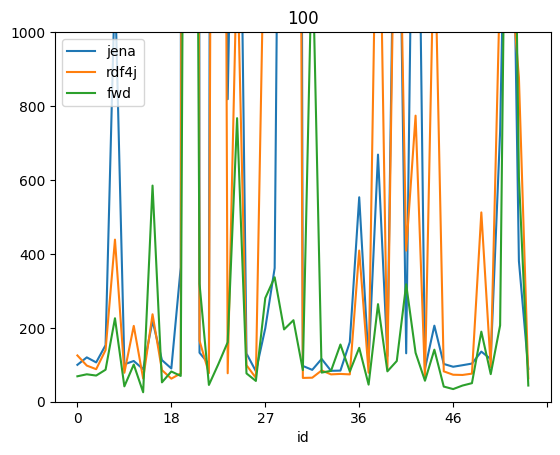

In [218]:
plot_dataset("100", lim=1000, incl_only=['fwd', 'jena', 'rdf4j'])

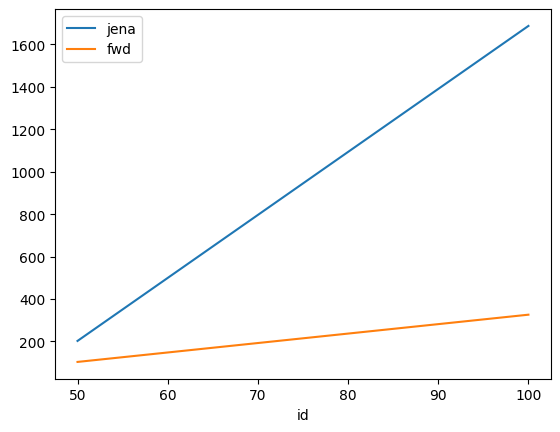

In [230]:
plot_all_datasets(incl_only=['jena', 'fwd'])